# Run Deep Q-Learning

## Initialize Environment

In [1]:
import env.fj_depolarize as fj
import importlib
importlib.reload(fj)

n_nodes = 12
k_steps = 4
env = fj.FJDepolarize(n=n_nodes, k=k_steps)


## Initialize DQN Agent and train

In [2]:
import agents.dqn as dqn
import wandb
import random
import string
# importlib.reload(dqn)

if not wandb.api.api_key:
    wandb.login(key="234e0f8aa341f24947a5f632a71bd6cae6a73a58")

embed_dim = 60
num_heads = 3
learning_rate = 0.0008
number_of_layers = 4
batch_size = 50 # standard is 50
random_code = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
architecture = "GraphSage"
approach = "simple"
run_name = f"{architecture}-{approach}-n{n_nodes}-k{k_steps}-hd{embed_dim}-heads{num_heads}-lr{learning_rate}-layers{number_of_layers}-bs{batch_size}-{random_code}"

agent = dqn.DQN(env, 
                model_architecture=architecture,
                qnet_approach=approach,
                embed_dim=embed_dim, 
                num_heads = num_heads,
                number_of_layers = number_of_layers,
                learning_rate=learning_rate, 
                batch_size=batch_size, 
                wandb_init=True,
                wand_run_name=run_name)

wandb: Currently logged in as: louistichelman (dll-streetview) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
agent.timesteps_train = 20000
agent.train()

In [3]:
run_name = 'GraphSage-complex-n12-k4-hd60-heads3-lr0.0008-layers4-bs50-FW9PS'


In [7]:
run_name

'GraphSage-simple-n12-k4-hd60-heads3-lr0.0008-layers4-bs50-IKFFE'

#### Save Parameters of Q Network

In [6]:
import torch

torch.save(agent.q_network.state_dict(), f"saved files/dqn_params/{run_name}_q_network_params.pth")
torch.save(agent.target_network.state_dict(), f"saved files/dqn_params/{run_name}_target_network_params.pth")

#### Load parameters from files if trained earlier

In [4]:
import torch

agent.q_network.load_state_dict(torch.load(f"saved files/dqn_params/{run_name}_q_network_params.pth"))
agent.target_network.load_state_dict(torch.load(f"saved files/dqn_params/{run_name}_target_network_params.pth"))
print("Agent initialized with saved parameters.")

Agent initialized with saved parameters.


## Evaluate Policy

In [5]:
import env.fj_depolarize_simple as ds
importlib.reload(ds)

n_nodes = 12
k_steps = 4
env = fj.FJDepolarize(n=n_nodes, k=k_steps)

env_simple = ds.DepolarizeSimple(n=n_nodes, k=k_steps, max_edges=None, generate_states=False)

random_state_list = []

seen = set()
while len(random_state_list)<1000:
    state = env.reset()
    G, sigma, tau, _ = state
    state_hash = env_simple.state_hash(G, sigma, tau)
    if state_hash in seen:
        continue
    seen.add(state_hash)
    random_state_list.append(state)

In [ ]:
import pickle

filename = f"random_state_list_n{n_nodes}_k{k_steps}.pkl"
with open(filename, "wb") as file:
    pickle.dump(random_state_list, file)

print(f"Random state list saved to {filename}")

Random state list saved to random_state_list_n12_k4.pkl


In [9]:
import pickle

filename = f"saved files/evaluation/random_state_list_n{n_nodes}_k{k_steps}.pkl"

with open(filename, "rb") as file:
    random_state_list = pickle.load(file)

print("Random state list loaded successfully.")

Random state list loaded successfully.


In [10]:
import utils.evaluation as ev
importlib.reload(ev)
from tqdm import tqdm

epsilon =  1e-4

polarization_gains = []
dqn_better = 0
greedy_better = 0
for state in tqdm(random_state_list):
    G, sigma, tau, _ = state
    num_edges = len(G.edges)
    polarization_start = env.polarization(G, sigma)
    _, polarization_dqn = ev.depolarize_policy(state, env, agent.policy_greedy)
    _, polarizarion_greedy = ev.depolarize_greedy(state, env)
    _, polarization_random = ev.depolarize_random(state, env)
    polarization_gains.append((num_edges,
                                polarization_start - polarization_dqn ,
                                polarization_start - polarizarion_greedy,
                                polarization_start - polarization_random))
    if abs(polarization_dqn - polarizarion_greedy) > epsilon:
        if polarization_dqn < polarizarion_greedy:
            dqn_better += 1
        else:
            greedy_better += 1
print(f"DQN better: {dqn_better}, Greedy better: {greedy_better}, total: 500")


100%|██████████| 500/500 [00:55<00:00,  9.08it/s]

DQN better: 27, Greedy better: 454, total: 500


In [25]:
dqn_better-greedy_better

-318

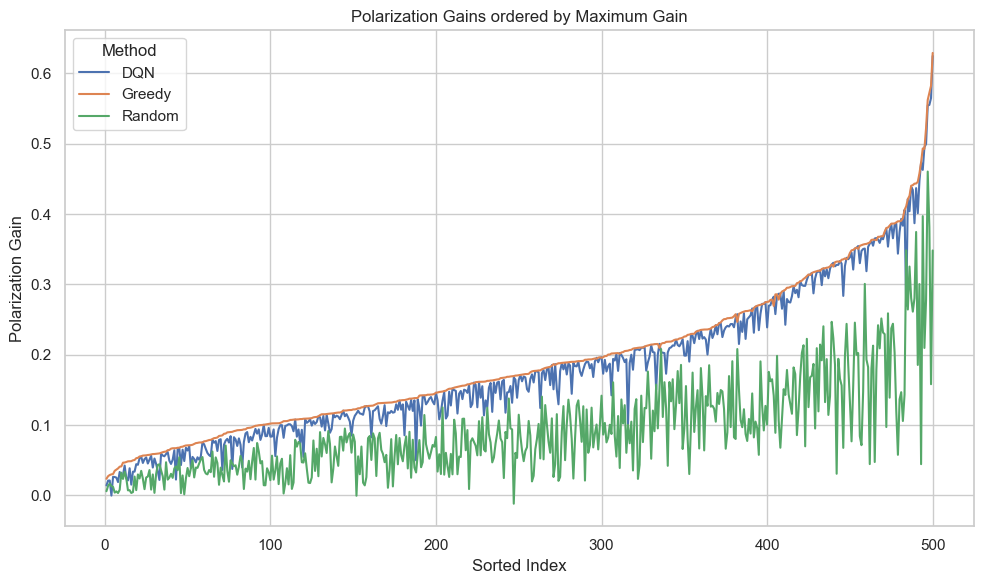

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

polarization_gains_without_edges = [(y, z, w) for _, y, z, w in polarization_gains]

# Step 1: Sort by max(triple)
polarization_gains_sorted = sorted(polarization_gains_without_edges, key=lambda t: max(t))

# Step 2: Prepare data for plotting
data = {
    'Index': [],
    'Gain': [],
    'Method': []
}

for i, (x, y, z) in enumerate(polarization_gains_sorted, start=1):
    data['Index'] += [i, i, i]
    data['Gain'] += [x, y, z]
    data['Method'] += ['DQN', 'Greedy', 'Random']

df = pd.DataFrame(data)

# Step 3: Plot with Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Index', y='Gain', hue='Method')#, marker='o')

plt.title('Polarization Gains ordered by Maximum Gain')
plt.xlabel('Sorted Index')
plt.ylabel('Polarization Gain')
plt.tight_layout()
plt.show()


In [24]:
(df["Gain"][df["Method"]=="DQN"].sum()-df["Gain"][df["Method"]=="Greedy"].sum())/500

np.float64(-0.0001979013968889376)

## Evaluation Gener

In [ ]:
import env.fj_depolarize_simple as ds
importlib.reload(ds)
import pickle


for n in [6, 8, 10, 12, 14, 16, 18, 20]:
    for k in [2, 3, 4, 5, 6]:
        n_nodes = n
        k_steps = k
        env = fj.FJDepolarize(n=n_nodes, k=k_steps)

        env_simple = ds.DepolarizeSimple(n=n_nodes, k=k_steps, max_edges=None, generate_states=False)

        random_state_list = []

        seen = set()
        while len(random_state_list)<500:
            state = env.reset()
            G, sigma, tau, _ = state
            state_hash = env_simple.state_hash(G, sigma, tau)
            if state_hash in seen:
                if three_times:
                    break
                if two_times:
                    three_times = True
                if one_times:
                    two_times = True
                one_times = True
                continue
            one_times = two_times = three_times = False
            seen.add(state_hash)
            random_state_list.append(state)

        filename = f"saved files/evaluation/random_state_list_n{n_nodes}_k{k_steps}.pkl"
        with open(filename, "wb") as file:
            pickle.dump(random_state_list, file)

        print(f"Random state list saved to {filename}")

In [12]:
from tqdm import tqdm
import utils.evaluation as ev
importlib.reload(ev)
import pickle


epsilon =  1e-4

results = {}
filename = f"saved files/evaluation/greedy_polarizations.pkl"
with open(filename, "rb") as file:
    greedy_polarizations = pickle.load(file)

for n in tqdm([6, 8, 10, 12, 14, 16, 18, 20]):
    for k in [2, 3, 4, 5, 6]:
        env = fj.FJDepolarize(n=n, k=k)

        filename = f"saved files/evaluation/random_state_list_n{n}_k{k}.pkl"
        with open(filename, "rb") as file:
            states = pickle.load(file)

        polarization_diff = 0
        dqn_better = 0
        greedy_better = 0
        for i, state in enumerate(states):
            G, sigma, tau, _ = state
            num_edges = len(G.edges)
            # polarization_start = env.polarization(G, sigma)
            _, polarization_dqn = ev.depolarize_policy(state, env, agent.policy_greedy)
            # _, polarizarion_greedy = ev.depolarize_greedy(state, env)
            # greedy_polarizations[(n,k)][i] = polarizarion_greedy
            # _, polarization_random = ev.depolarize_random(state, env)
            polarization_diff = polarization_diff + polarization_dqn - greedy_polarizations[(n,k)][i]
            if abs(polarization_dqn - greedy_polarizations[(n,k)][i]) > epsilon:
                if polarization_dqn < greedy_polarizations[(n,k)][i]:
                    dqn_better += 1
                else:
                    greedy_better += 1
        results[(n,k)] = {"number_states": len(states),
                            "dqn_better": dqn_better,
                          "greedy_better": greedy_better,
                          "difference": polarization_diff}
        

100%|██████████| 8/8 [07:33<00:00, 56.71s/it]


In [13]:
import pickle

with open(f"saved files/evaluation/results_run_{run_name}.pkl", "wb") as file:
    pickle.dump(results, file)

print("Results saved to results.pkl")

Results saved to results.pkl


In [22]:
import pickle

filename = f"saved files/evaluation/greedy_polarizations.pkl"
with open(filename, "wb") as file:
    pickle.dump(greedy_polarizations, file)

print(f"Greedy polarizations saved to {filename}")

Greedy polarizations saved to saved files/evaluation/greedy_polarizations.pkl


In [ ]:
import pickle

with open(f"results_run_{run_name}.pkl", "wb") as file:
    pickle.dump(results, file)



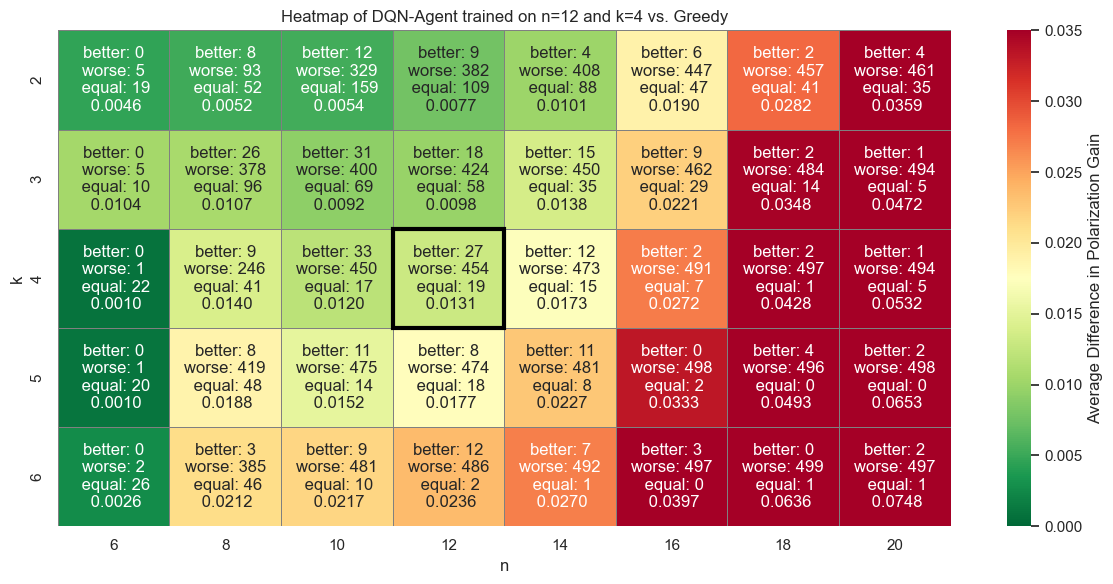

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import numpy as np
import pandas as pd

# Example format of your results dictionary:
# results[(n, k)] = {
#     "number_states": 10,
#     "dqn_better": 6,
#     "greedy_better": 2,
#     "difference": 4
# }

# Define the ranges
n_values = [6, 8, 10, 12, 14, 16, 18, 20]
k_values = [2, 3, 4, 5, 6]

# Create matrices for annotations and heatmap coloring
annot_matrix = []
color_matrix = []

for k in k_values:
    row_annot = []
    row_color = []
    for n in n_values:
        key = (n, k)
        if key in results:
            r = results[key]
            num = r["number_states"]
            dqn = r["dqn_better"]
            greedy = r["greedy_better"]
            diff = r["difference"]
            diff_norm = diff / num if num != 0 else 0

            # Annotation text
            # annot = f"Better: {dqn}/{num}\n{greedy}/{num}\n{diff_norm:.4f}"            
            annot = f"better: {dqn}\nworse: {greedy}\n equal: {num-dqn-greedy}\n {diff_norm:.4f}"

            row_annot.append(annot)
            row_color.append(diff_norm)
        else:
            row_annot.append("")
            row_color.append(np.nan)
    annot_matrix.append(row_annot)
    color_matrix.append(row_color)

# Convert to DataFrame for seaborn
annot_df = pd.DataFrame(annot_matrix, index=k_values, columns=n_values)
color_df = pd.DataFrame(color_matrix, index=k_values, columns=n_values)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.heatmap(color_df, annot=annot_df, fmt='', cmap="RdYlGn_r", cbar_kws={'label': 'Average Difference in Polarization Gain'}, linewidths=0.5, linecolor='gray', vmin=0, vmax=0.035)

# Add red rectangle around cell (n=12, k=4)
n_target = 12
k_target = 4

# Get the row and column indices in the matrix
row_idx = k_values.index(k_target)
col_idx = n_values.index(n_target)

# Rectangle parameters: (x, y) is the bottom left of the cell
rect = patches.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='black', linewidth=3)
ax.add_patch(rect)

plt.xlabel("n")
plt.ylabel("k")
plt.title("Heatmap of DQN-Agent trained on n=12 and k=4 vs. Greedy")
plt.tight_layout()
plt.show()


### Code for training Q network directly on optimal values 

In [ ]:
import env.fj_depolarize_simple as depolarize_simple
importlib.reload(depolarize_simple)

env_simple = depolarize_simple.DepolarizeSimple(n=n_nodes, k=k_steps, max_edges=max_edges)

In [ ]:
import agents.q_learning as q_learning
importlib.reload(q_learning)

agent_qlearning = q_learning.QLearning(env_simple)

q_table = agent_qlearning.train(
    n_training_episodes=100000,
    min_epsilon=0.2,
    max_epsilon=1.0,
    decay_rate=0.000005,
    learning_rate=1
)

100%|██████████| 100000/100000 [01:48<00:00, 922.23it/s]


In [ ]:
def optimal_policy(state, action):
    G, sigma, tau, l = state
    state_hash, action_perm = env_simple.state_hash(G, sigma, tau, action)
    state_idx = env_simple.hash_to_index[(state_hash, l)]
    return q_table[state_idx, action_perm]

In [ ]:
def optimal_action(state):
    best_action = None
    best_value = float('-inf')
    for action in range(5):  # Assuming actions are 0, 1, 2, 3, 4
        value = optimal_policy(state, action)
        if value > best_value:
            best_value = value
            best_action = action
    return best_action

In [ ]:
import utils.evaluation as ev
importlib.reload(ev)
import env.fj_depolarize_simple as ds
importlib.reload(ds)


# env_simple = ds.DepolarizeSimple(n=n_nodes, k=k_steps, max_edges=max_edges)

epsilon =  1e-6
seen = set()
dqn_better = 0
greedy_better = 0
for _ in range(1000):
    state = env.reset()
    G, sigma, tau, l = state
    state_hash = env_simple.state_hash(G, sigma, tau)
    if state_hash in seen:
        continue
    seen.add(state_hash)
    _, polarization_dqn = ev.depolarize_policy(state, env, optimal_action)
    _, polarizarion_greedy = ev.depolarize_greedy(state, env)
    if abs(polarization_dqn - polarizarion_greedy) > epsilon:
        print(f"Polarization DQN: {polarization_dqn}, Polarization Greedy: {polarizarion_greedy}")
        if polarization_dqn < polarizarion_greedy:
            dqn_better += 1
        else:
            greedy_better += 1
print(f"DQN better: {dqn_better}, Greedy better: {greedy_better}")

Polarization DQN: 0.8219949365267865, Polarization Greedy: 0.8289331562404733
Polarization DQN: 0.9833321660356333, Polarization Greedy: 1.0305970005364815
Polarization DQN: 1.404625563263382, Polarization Greedy: 1.414033184891605
Polarization DQN: 0.9833321660356333, Polarization Greedy: 1.0305970005364817
Polarization DQN: 0.9833321660356336, Polarization Greedy: 1.029592181429162
Polarization DQN: 0.8219949365267866, Polarization Greedy: 0.8289331562404733
Polarization DQN: 1.404625563263382, Polarization Greedy: 1.414033184891605
Polarization DQN: 0.9833321660356336, Polarization Greedy: 1.029592181429162
DQN better: 8, Greedy better: 0


In [ ]:
epsilon = 1e-3
not_optimal = 0
for _ in range(100):
    state = env.reset()
    state, reward, done = env.step(0)
    # state, reward, done = env.step(0)
    with torch.no_grad():
        q_values = agent.q_network(agent.prepare_graph_for_qnet(state))
    optimal_indices = [i for i in range(len(q_values)) if optimal_policy(state, i) > max(optimal_policy(state, j)-epsilon for j in range(len(q_values)))]
    if q_values.argmax().item() not in optimal_indices:
        not_optimal += 1
        print(f"Q values: {q_values}, optimal values: {[optimal_policy(state, i) for i in range(len(q_values))]}")
        break
print(f"Number of non-optimal actions in 100 random states: {not_optimal}")

Q values: tensor([[ 0.1573],
        [ 0.1556],
        [ 0.1220],
        [-0.0261],
        [ 0.1520]]), optimal values: [np.float64(0.10527169448890339), np.float64(0.11695018041951877), np.float64(0.10754255879129615), np.float64(0.0), np.float64(0.10527169448890272)]
Number of non-optimal actions in 100 random states: 1


In [ ]:
import torch

env.reset()
state, reward, done = env.step(0)
state, reward, done = env.step(0)
# state, reward, done = env.step(0)
print(agent.prepare_graph_for_qnet(state).x)
print(agent.prepare_graph_for_qnet(state).edge_index)

with torch.no_grad():
    q_values = agent.q_network(agent.prepare_graph_for_qnet(state))

for i in range(len(q_values)):
    print(f"optimal: {optimal_policy(state, i):.3f}, q_value: {q_values[i].item():.3f}")


tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [ 1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])
tensor([[2, 3, 3, 4],
        [3, 4, 2, 3]])
optimal: 0.174, q_value: 0.178
optimal: 0.174, q_value: 0.178
optimal: 0.174, q_value: 0.234
optimal: 0.059, q_value: 0.053
optimal: 0.114, q_value: 0.146
